In [1]:
from IPython.display import display, Image

# CNTK 103: パート D - MNIST での畳み込みニューラルネットワーク (CNTK 103: Part D - Convolutional Neural Network with MNIST)

CNTK 103 パート Aを正常に完了していることを前提としています。

We assume that you have successfully completed CNTK 103 Part A (MNIST Data Loader).

このチュートリアルでは、MNIST データで畳み込みニューラル ネットワーク (CNN) を訓練します。 このノートブックは、Python API を使ったレシピを提供します。 BrainScript でのこの例題をお探しの場合は、[こちら](https://github.com/Microsoft/CNTK/tree/release/2.1/Examples/Image/GettingStarted) をご覧ください。

In this tutorial we will train a Convolutional Neural Network (CNN) on MNIST data. This notebook provides the recipe using the Python API. If you are looking for this example in BrainScript, please look [here](https://github.com/Microsoft/CNTK/tree/release/2.1/Examples/Image/GettingStarted)

## はじめに (Introduction)

[畳み込みニューラルネットワーク](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN、またはConvNet) は、103C で紹介した通常の複数層パーセプトロン (MLP) ネットワークによく似た、学習可能な重みとバイアスを持つニューロンで構成された、[フィード フォワード](https://en.wikipedia.org/wiki/Feedforward_neural_network)人工ニューラルネットワークの一種です。CNNは、データの空間的性質を利用します。自然界では、さまざまなオブジェクトをその形、サイズ、色で認識します。例えば、自然の風景の物体は、エッジ、(2 つ以上のエッジによって定義される) コーナー/頂点、カラー パッチなどです。これらのプリミティブは、異なる検出器 (エッジ検出、色検出器など)、または、実世界の視覚関連タスクにおける画像解釈 (物体分類、関心領域検出、シーン記述など) を容易にするために相互作用する検出器の組み合わせによって識別されます。これらの検出器は、フィルターとも呼ばれます。畳み込みは、画像とフィルターを入力として受け取り、(入力画像におけるエッジ、コーナー、色などを表す) フィルター処理された出力を生成する数学的演算子です。歴史的には、これらのフィルターは、手動作成されるか、または数学的関数 (例えば、[ガウシアン](https://en.wikipedia.org/wiki/Gaussian_filter) / [ラプラシアン](http://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm) / [キャニー]（https://en.wikipedia.org/wiki/Canny_edge_detector）フィルター) でした。フィルター出力は、[ニューロン](https://en.wikipedia.org/wiki/Neuron) と呼ばれる、人間の脳細胞を模倣する非線形活性化関数によってマッピングされます。

A [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN, or ConvNet) is a type of [feed-forward](https://en.wikipedia.org/wiki/Feedforward_neural_network) artificial neural network made up of neurons that have learnable weights and biases, very similar to ordinary multi-layer perceptron (MLP) networks introduced in 103C. The CNNs take advantage of the spatial nature of the data. In nature, we perceive different objects by their shapes, size and colors. For example, objects in a natural scene are typically edges, corners/vertices (defined by two of more edges), color patches etc. These primitives are often identified using different detectors (e.g., edge detection, color detector) or combination of detectors interacting to facilitate image interpretation (object classification, region of interest detection, scene description etc.) in real world vision related tasks. These detectors are also known as filters. Convolution is a mathematical operator that takes an image and a filter as input and produces a filtered output (representing say egdges, corners, colors etc in the input image).  Historically, these filters are a set of weights that were often hand crafted or modeled with mathematical functions (e.g., [Gaussian](https://en.wikipedia.org/wiki/Gaussian_filter) / [Laplacian](http://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm) / [Canny](https://en.wikipedia.org/wiki/Canny_edge_detector) filter).  The filter outputs are mapped through non-linear activation functions mimicking human brain cells called [neurons](https://en.wikipedia.org/wiki/Neuron).

畳み込みネットワークは、明示的な数学モデルの代わりに、データからこれらのフィルターを直接学習するための機構を提供し、歴史的に作られたフィルターと比較して優れていることが実証されています。畳み込みネットワークでは、全結合された一対の (入出力間の) 重み付けを個々に学習するのではなく、フィルター重みを学習することに重点を置いています。このようにして、前のチュートリアルの従来型の MLP ネットワークと比較して、学習する重みの数が減りました。畳み込みネットワークでは、ネットワークの複雑さに応じて、数個から数千のフィルターを学習します。

Convolutional networks provide a machinery to learn these filters from the data directly instead of explicit mathematical models and have been found to be superior (in real world tasks) compared to historically crafted filters.  With convolutional networks, the focus is on learning the filter weights instead of learning individually fully connected pair-wise (between inputs and outputs) weights. In this way, the number of weights to learn is reduced when compared with the traditional MLP networks from the previous tutorials.  In a convolutional network, one learns several filters ranging from few single digits to few thousands depending on the network complexity.

CNN プリミティブの多くは、脳の[視覚野](https://en.wikipedia.org/wiki/Visual_cortex)に概念的に似たコンポーネントを持つことが示されています。視覚野におけるニューロン細胞群は、刺激されると応答を発します。この領域は、受容野 (RF) として知られています。同様に、畳み込みにおいて、フィルター次元に対応する入力領域を、受容野とみなすことができます。さまざまな[コンピューター ビジョン](https://en.wikipedia.org/wiki/Computer_vision) タスクに使われている ([AlexNet](https://en.wikipedia.org/wiki/AlexNet)、[VGG](https://arxiv.org/abs/1409.1556)、[Inception](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)、[ResNet](https://arxiv.org/pdf/1512.03385v1.pdf) といった) 人気の高い ディープ CNN/ConvNetは、(生物学からインスピレーションによる) こういったアーキテクチャ プリミティブ の多くを持っています。

Many of the CNN primitives have been shown to have a conceptually parallel components in brain's [visual cortex](https://en.wikipedia.org/wiki/Visual_cortex). The group of neurons cells in visual cortex emit responses when stimulated. This region is known as the receptive field (RF). Equivalently, in convolution the input region corresponding to the filter dimensions can be considered as the receptive field. Popular deep CNNs or ConvNets (such as [AlexNet](https://en.wikipedia.org/wiki/AlexNet), [VGG](https://arxiv.org/abs/1409.1556), [Inception](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf), [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf)) that are used for various [computer vision](https://en.wikipedia.org/wiki/Computer_vision) tasks have many of these architectural primitives (inspired from biology).  

このチュートリアルでは、畳み込み演算を紹介し、CNN のさまざまなパラメーターに慣れ親しみます。

In this tutorial, we will introduce the convolution operation and gain familiarity with the different parameters in CNNs.

**問題**：CNTK 103C のように、我々は、MNIST データの数字を認識するという同じ問題に引き続き取り組みます。 MNIST データは、背景ノイズの少ない手書き数字で構成されています。

**Problem**:
As in CNTK 103C, we will continue to work on the same problem of recognizing digits in MNIST data. The MNIST data comprises of hand-written digits with little background noise.

In [2]:
# Figure 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

目標: 我々の目標は、MNIST データ セットの数字を識別する分類器を訓練することです。

**Goal**:
Our goal is to train a classifier that will identify the digits in the MNIST dataset. 

**アプローチ**: 前のチュートリアルで使用したのと同じ5つの段階 (データの読み取り、データの前処理、モデルの作成、モデル パラメーターの学習、モデルの評価 (テスト/予測)) が適用可能です。

**Approach**:

The same 5 stages we have used in the previous tutorial are applicable: Data reading, Data preprocessing, Creating a model, Learning the model parameters and Evaluating (a.k.a. testing/prediction) the model. 
- データの読み取り：CNTK テキスト リーダーを使用します。
- データの前処理: パート A (オプションの推奨セクション) に記載されています。
- Data reading: We will use the CNTK Text reader 
- Data preprocessing: Covered in part A (suggested extension section). 

このチュートリアルでは、アーキテクチャの異なるコンポーネントを持つ 2 つのモデルを実験します。

In this tutorial, we will experiment with two models with different architectural components.

In [3]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

## データの読み取り (Data reading)
このセクションでは、CNTK 103 パート A で生成されたデータを読み取ります。

In this section, we will read the data generated in CNTK 103 Part A (MNIST Data Loader).

このチュートリアルでは、CNTK_103A_MNIST_DataLoader ノートブックを使用してダウンロードした MNIST データを使用しています。このデータ セットは、60,000 の訓練画像と 10,000 のテスト画像を持ち、各画像は 28 × 28 ピクセルです。従って、特徴の数は、1ピクセルあたり 1 つで、784 (= 28 × 28 ピクセル) です。 変数「num_output_classes」は、データセットの数字 (0 - 9) に対応する 10 に設定されています。

We are using the MNIST data that you have downloaded using the CNTK_103A_MNIST_DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels. Thus the number of features is equal to 784 (= 28 x 28 pixels), 1 per pixel. The variable `num_output_classes` is set to 10 corresponding to the number of digits (0-9) in the dataset.

前のチュートリアルでは、以下に示すように、入力画像を常にベクトルに平坦化していました。畳み込みネットワークでは、画像をこのように平坦化しません。

In previous tutorials, as shown below, we have always flattened the input image into a vector.  With convoultional networks, we do not flatten the image in this way.

![MNIST-flat](https://www.cntk.ai/jup/cntk103a_MNIST_input.png)

**入力次元 (Input Dimensions)**:  

画像の畳み込みネットワークでは、入力データはしばしばピクセル間の空間的関係を保存する 3次元行列 (チャネル数、画像の幅、高さ) として形成されます。上の図では、MNIST 画像は単一チャネル (グレースケール) データのため、入力次元は (1, 画像の幅, 画像の高さ) タプルとして指定されています。

In convolutional networks for images, the input data is often shaped as a 3D matrix (number of channels, image width, height), which preserves the spatial relationship between the pixels. In the figure above, the MNIST image is a single channel (grayscale) data, so the input dimension is specified as a (1, image width, image height) tuple. 

![input-rgb](https://www.cntk.ai/jup/cntk103d_rgb.png)

自然風景のカラー画像は、しばしば赤/緑/青 (RGB) カラー チャネルとして提示されます。そのような画像の入力次元は、(3, 画像の幅, 画像の高さ) タプルとして指定されます。RGB 入力データが、ボリューム幅、高さ、深さが 3 軸を表す 3 次元スキャンの場合、入力データ フォーマットは4値 (3, ボリュームの幅, ボリュームの高さ, ボリュームの深さ) のタプルで指定されます。このようにして、CNTK は任意の高次元空間における入力画像の指定を可能にします。

Natural scene color images are often presented as Red-Green-Blue (RGB) color channels. The input dimension of such images are specified as a (3, image width, image height) tuple. If one has RGB input data as a volumetric scan with volume width, volume height and volume depth representing the 3 axes, the input data format would be specified by a tuple of 4 values (3, volume width, volume height, volume depth). In this way CNTK enables specification of input images in arbitrary higher-dimensional space.

In [5]:
# Define the data dimensions
input_dim_model = (1, 28, 28)    # images are 28 x 28 with 1 channel of color (gray)
input_dim = 28*28                # used by readers to treat input data as a vector
num_output_classes = 10

**データ形式** データは、CNTK CTF 形式でローカルマシンに保存されます。CTF形式は一連のサンプルを含む単純なテキスト形式であり、各サンプルは一連の名前付きフィールドとそのデータを含みます。我々の MNIST データでは、各サンプルにラベルと特徴という 2 つのフィールドが含まれています。

**Data Format** The data is stored on our local machine in the CNTK CTF format.  The CTF format is a simple text format that contains a set of samples with each sample containing a set of named fields and their data.  For our MNIST data, each sample contains 2 fields: labels and feature, formatted as:

    |labels 0 0 0 1 0 0 0 0 0 0 |features 0 255 0 123 ... 
                                                  (それぞれがピクセルのグレイ レベルを表す、784 個の整数)
                                                  (784 integers each representing a pixel gray level)
    
このチュートリアルでは、「features」という名前の整数ストリームに対応する画像ピクセルを使用します。[CTF デシリアライザー]((https://cntk.ai/pythondocs/cntk.io.html#cntk.io.CTFDeserializer))を使用して訓練データとテストデータを読み込む「create_reader」関数を定義します。

In this tutorial we are going to use the image pixels corresponding to the integer stream named "features". We define a `create_reader` function to read the training and test data using the [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html#cntk.io.CTFDeserializer). . 

ラベルは、第 1 インデックスが数字「0」に対応し、最後のインデックスがは数字「9」に対応する[ワン ホット](https://en.wikipedia.org/wiki/One-hot)でエンコードされています (10 個の数字のために 10 のクラスがあるので、3 の出力クラスを表すラベルは「0001000000」になります)。

The labels are [1-hot](https://en.wikipedia.org/wiki/One-hot) encoded (the label representing the output class of 3  becomes `0001000000` since we have 10 classes for the 10 possible digits), where the first index corresponds to digit `0` and the last one corresponds to digit `9`.

![mnist-label](https://www.cntk.ai/jup/cntk103a_onehot.png)

In [6]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [7]:
# Ensure the training and test data is available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.

data_found=False # A flag to indicate if train/test data found in local cache
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    
    train_file=os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file=os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is ..\Examples\Image\DataSets\MNIST


<a id='#Model Creation'></a>
## CNN モデルの作成 (CNN Model Creation)

CNNは、1つの層の出力が次の層への入力となるような方法で、(MLPに似た) 多数の層から構成されるフィード フォワード ネットワークです。MLPでは、可能なすべてのペアの入力ピクセルが出力ノードに接続され、各ペアは重みを持ち、学習するパラメーターの組み合わせ爆発を招き、過学習の可能性も高めます ([詳細](http://cs231n.github.io/neural-networks-1/))。畳み込み層は、ピクセルの空間的配置を利用し、ネットワーク内のパラメーター量を大幅に削減する複数のフィルターを学習します ([詳細](http://cs231n.github.io/convolutional-networks/))。 フィルターのサイズは、畳み込み層のパラメーターです。

CNN is a feedforward network made up of bunch of layers in such a way that the output of one layer becomes the input to the next layer (similar to MLP). In MLP, all possible pairs of input pixels are connected to the output nodes with each pair having a weight, thus leading to a combinatorial explosion of parameters to be learnt and also increasing the possibility of overfitting ([details](http://cs231n.github.io/neural-networks-1/)). Convolution layers take advantage of the spatial arrangement of the pixels and learn multiple filters that significantly reduce the amount of parameters in the network ([details](http://cs231n.github.io/convolutional-networks/)). The size of the filter is a parameter of the convolution layer.  

このセクションでは、畳み込み演算の基本を紹介します。このチュートリアルで使用している MNIST データはグレースケール画像 (単一チャネル) ですが、RGB 画像 (3 チャンネル) の文脈で図示します。

In this section, we introduce the basics of convolution operations. We show the illustrations in the context of RGB images (3 channels), eventhough the MNIST data we are using in this tutorial is a grayscale image (single channel).

![input-rgb](https://www.cntk.ai/jup/cntk103d_rgb.png)

### 畳み込み層 (Convolution Layer)

畳み込み層は、一連のフィルターです。 各フィルターは、重み (**W**) 行列とバイアス ($b$) によって定義されます。

A convolution layer is a set of filters. Each filter is defined by a weight (**W**) matrix, and  bias ($b$).

![input-filter](https://www.cntk.ai/jup/cntk103d_filterset.png)

これらのフィルターは、画像にわたって、重み付けと対応する入力値 ($\vec{x}^T$) との間でドット積を実行して走査されます。 バイアス値は、ドット積の出力に加算され、結果として得られる合計は、オプションとして、活性化関数を介してマッピングされます。このプロセスは、次のアニメーションで説明されています。

These filters are scanned across the image performing the dot product between the weights and corresponding input value ($\vec{x}^T$). The bias value is added to the output of the dot product and the resulting sum is optionally mapped through an activation function. This process is illustrated in the following animation.

In [8]:
Image(url="https://www.cntk.ai/jup/cntk103d_conv2d_final.gif", width= 300)

畳み込み層には、以下の重要な機能が組み込まれています。

Convolution layers incorporate following key features:

- 入力ノードと出力ノードのすべてのペアに全結合される代わりに、各畳み込みノードは、受容野 (RF) とも呼ばれる小さな入力領域にローカライズされた入力ノードのサブセットに**ローカル接続**されます。上図は、RF領域としての画像内の小さな3 x 3領域を示しています。 RGB画像の場合、3つの3×3の領域があり、3つの色チャネルのそれぞれが1つ存在する。
   
   
   - Instead of being fully-connected to all pairs of input and output nodes , each convolution node is **locally-connected** to a subset of input nodes localized to a smaller input region, also referred to as receptive field (RF). The figure above illustrates a small 3 x 3 regions in the image as the RF region. In the case of an RGB, image there would be three such 3 x 3 regions, one each of the 3 color channels. 
   
   
 - 畳み込み層には、(緻密層にあるような) 単一の重みのセットではなく、**フィルター**と呼ばれる (図では複数の色で表示されている) 複数のセットがあります。各フィルターは、入力画像内のそれぞれの可能な RF 内の特徴を検出します。畳み込みの出力は、（下のアニメーションに示されている）「n」サブ層のセットであり、ここで「n」はフィルター数である (上図を参照)。
   
     
   - Instead of having a single set of weights (as in a Dense layer), convolutional layers have multiple sets (shown in figure with multiple colors), called **filters**. Each filter detects features within each possible RF in the input image.  The output of the convolution is a set of `n` sub-layers (shown in the animation below) where `n` is the number of filters (refer to the above figure).  
   
     
 - サブ層内では、各ノードが独自の重みのセットを持つのではなく、そのサブ層内のすべてのノードによって単一の**共有の重み**のセットが使用されます。これにより、学習すべきパラメーター数と過学習が減ります。 これはまた、非常に実用的なソリューションを構築可能にする、深層学習のいくつかの側面のための扉を開きます。
   
     
- Within a sublayer, instead of each node having its own set of weights, a single set of **shared weights** are used by all nodes in that sublayer. This reduces the number of parameters to be learnt and thus overfitting. This also opens the door for several aspects of deep learning which has enabled very practical solutions to be built:


- より大きな画像 (たとえば 512 x 512) を処理する。
- (より大きな RF に対応する) より大きなフィルター サイズ (たとえば 11 x 11) を試す。
- より多くのフィルター (たとえば 128) を学習する。
- より深いアーキテクチャ (100 以上の層) を探る
- 変換不変性 (画像内のどこに現れるかに関係なく、特徴を認識する能力) を達成する。


- Handling larger images (say 512 x 512)
- Trying larger filter sizes (corresponding to a larger RF) say 11 x 11
- Learning more filters (say 128)
- Explore deeper architectures (100+ layers)
- Achieve translation invariance (the ability to recognize a feature independent of where they appear in the image). 

### ストライド、パッド パラメーター (Strides and Pad parameters)

**フィルターの位置付け方法** 一般的に、フィルターは、左から右、上から下に重なるタイルで配置されます。各畳み込み層には「filter_shape」を指定するパラメーターがあり、ほとんどの自然風景画像の場合にフィルターの幅と高さを指定します。行内の複数の RF を介してフィルターを移動するときの右に進む距離と、次の行に移動するときにどのくらい下に進むかを制御するパラメーター (「strides」) があります。 ブール型パラメーター「pad」は、境界の近くの RF の完全なタイリングを可能にするために、入力がパディングされるべきかどうかを制御します。

**How are filters positioned?** In general, the filters are arranged in overlapping tiles, from left to right, and top to bottom.  Each convolution layer has a parameter to specify the `filter_shape`, specifying the width and height of the filter in case most natural scene images.  There is a parameter (`strides`) that controls the how far to step to right when moving the filters through multiple RF's in a row, and how far to step down when moving to the next row.  The boolean parameter `pad` controls if the input should be padded around the edges to allow a complete tiling of the RF's near the borders. 

上記のアニメーションは、filter_shape = (3, 3)、strides = (2, 2)、pad = False の結果を示しています。 以下の 2 つのアニメーションは、「pad」が True に設定されたときの結果を示しています。1 つ目はストライドが 2、2 つ目はストライドが 1 です。注: 出力の形状（ティール層）は、2 つのストライド設定の間で異なります。多くの場合、パディングの決定と選択するストライド値は、必要な出力層の形状に基づいています。

The animation above shows the results with a `filter_shape` = (3, 3), `strides` = (2, 2) and `pad` = False. The two animations below show the results when `pad` is set to True. First, with a stride of 2 and second having a stride of 1.
Note: the shape of the output (the teal layer) is different between the two stride settings. Many a times your decision to pad and the stride values to choose are based on the shape of the output layer needed.

In [9]:
# Plot images with strides of 2 and 1 with padding turned on
images = [("https://www.cntk.ai/jup/cntk103d_padding_strides.gif" , 'With stride = 2'),
          ("https://www.cntk.ai/jup/cntk103d_same_padding_no_strides.gif", 'With stride = 1')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=200, height=200))

With stride = 2


With stride = 1


## 独自の CNN モデルの構築 (Building our CNN models) 

この CNN チュートリアルでは、最初に 2 つのコンテナーを定義します。 1 つ目は入力の MNIST 画像用であり、2 つ目は 10 個の数字に対応するラベルです。データを読むとき、リーダーは画像ごとに 784 ピクセルを「input_dim_model」タプルで定義された形状に自動的にマッピングします (この例では (1, 28, 28) に設定されています)。

In this CNN tutorial, we first define two containers. One for the input MNIST image and the second one being the labels corresponding to the 10 digits. When reading the data, the reader automatically maps the 784 pixels per image to a shape defined by `input_dim_model` tuple (in this example it is set to (1, 28, 28)).

In [10]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

我々が構築する最初のモデルは、単純な畳み込みのみのネットワークです。ここには、2 つの畳み込み層があります。 我々の課題は MNIST データベースの 10 個の数字を検出することであるため、ネットワークの出力は、1 要素が各数字に対応する長さ 10のベクトルでなければなりません。これは、出力が「num_output_classes」である緻密層を使用して、最後の畳み込み層の出力を投影することによって達成されます。これまでロジスティック回帰と MLP では、特徴が最終層のクラス数にマッピングされていました。また、訓練中に「交差エントロピー」損失関数と組み合わされた「ソフトマックス」演算を使用するので (下記のいくつかのセルを参照)、最終的な緻密層はそれに関連する活性化関数を持たないことに注意してください。

The first model we build is a simple convolution only network. Here we have two convolutional layers. Since, our task is to detect the 10 digits in the MNIST database, the output of the network should be a vector of length 10, 1 element corresponding to each digit. This is achieved by projecting the output of the last convolutional layer using a dense layer with the output being `num_output_classes`. We have seen this before with Logistic Regression and MLP where features were mapped to the number of classes in the final layer. Also, note that since we will be using the `softmax` operation that is combined with the `cross entropy` loss function during training (see a few cells below), the final dense layer has no activation function associated with it.

次の図は、構築しようとしているモデルを示しています。以下のモデルのパラメーターは、実験されるべきものであることに注意してください。これらは、しばしばネットワーク ハイパー パラメーターと呼ばれます。フィルター形状を増やすと、モデル パラメーター数が増加し、計算時間が長くなり、モデルがデータにうまく収まるようになります。ただし、[過学習](https://en.wikipedia.org/wiki/Overfitting) のリスクがあります。通常、より深い層のフィルター数は、その前の層のフィルター数よりも多くなります。我々は、第 1 層と第 2 層でそれぞれ 8、16を選択しました。これらのハイパー パラメーターは、モデル構築中に実験すべきでものです。

The following figure illustrates the model we are going to build. Note the parameters in the model below are to be experimented with. These are often called network hyperparameters. Increasing the filter shape leads to an increase in the number of model parameters, increases the compute time and helps the model better fit to the data. However, one runs the risk of [overfitting](https://en.wikipedia.org/wiki/Overfitting). Typically, the number of filters in the deeper layers are more than the number of filters in the layers before them. We have chosen 8, 16 for the first and second layers, respectively. These hyperparameters should be experimented with during model building.

![conv-only](https://www.cntk.ai/jup/cntk103d_convonly2.png)

In [11]:
# function to build model

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
            h = features
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                       pad=True, name='second_conv')(h)
            r = C.layers.Dense(num_output_classes, activation=None, name='classify')(h)
            return r

モデルのインスタンスを作成し、モデルのさまざまなコンポーネントを検査しましょう。「z」は、ネットワークの出力を表すために使われます。このモデルでは、「relu」活性化関数を使用します。注: 「C.layers.default_options」を使うことは、簡潔なモデルを書くためのエレガントな方法です。これは、モデリング エラーを最小限に抑え、貴重なデバッグ時間を節約するための鍵です。

Let us create an instance of the model and inspect the different components of the model. `z` will be used to represent the output of a network. In this model, we use the `relu` activation function. Note: using the `C.layers.default_options` is an elegant way to write concise models. This is key to minimizing modeling errors, saving precious debugging time.

In [12]:
# Create the model
z = create_model(x)

# Print the output shapes / parameters of different components
print("Output Shape of the first convolution layer:", z.first_conv.shape)
print("Bias value of the last dense layer:", z.classify.b.value)

Output Shape of the first convolution layer: (8, 14, 14)
Bias value of the last dense layer: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


推定されるモデル パラメーター数を理解することは、持つ必要があるデータ量に直接依存するため、深層学習の鍵です。過学習を防止するために、より多くのパラメーターを持つモデルに対して、より多くのデータが必要です。言い換えれば、固定量のデータでは、パラメーター数を制限しなければなりません。1 つのモデルに必要なデータ量に黄金律はありません。しかし、[データ拡大](https://deeplearningmania.quora.com/The-Power-of-Data-Augmentation-2) でモデル訓練のパフォーマンスを向上させる方法があります。

Understanding number of model parameters to be estimated is key to deep learning since there is a direct dependency on the amount of data one needs to have. You need more data for a model that has larger number of parameters to prevent overfitting. In other words, with a fixed amount of data, one has to constrain the number of parameters. There is no golden rule between the amount of data one needs for a model. However, there are ways one can boost performance of model training with [data augmentation](https://deeplearningmania.quora.com/The-Power-of-Data-Augmentation-2). 


In [13]:
# Number of parameters in the network
C.logging.log_number_of_parameters(z)

Training 11274 parameters in 6 parameter tensors.


**パラメーターの理解 (Understanding Parameters)**:


我々のモデルは、それぞれ重みとバイアスを持つ、2 つの畳み込み層を持っています。これにより、最大 4 つのパラメーター テンソルが追加されます。さらに、緻密層は、重みテンソルとバイアス テンソルを持ちます。従って、6 つのパラメータ テンソルがあります。

Our model has 2 convolution layers each having a weight and bias. This adds up to 4 parameter tensors. Additionally the dense layer has weight and bias tensors. Thus, the 6 parameter tensors.

今度は、パラメーター数を数えましょう。

Let us now count the number of parameters:

- *第 1 畳み込み層*: 各サイズが (1 × 5 × 5) の 8 つのフィルターがあり、1 は入力画像のチャネル数です。これにより、重み行列に最大 200 個の値と 8 個のバイアス値が追加されます。


- *第2畳み込み層*: 各サイズが (8 × 5 × 5) の 16 個のフィルターがあり、8 は第 2 レイヤ (= 第 1 レイヤの出力) への入力におけるチャネル数です。これにより、重み行列に最大 3,200 個の値と 16 個のバイアス値が追加されます。


- *最後の緻密層*：16 x 7 x 7 の入力値があり、MNIST データ セットの 10 個の数字に対応する 10 個の出力値を生成します。これは、(16 × 7 × 7) × 10 個の重み値と 10 個のバイアス値に対応します。

- *First convolution layer*: There are 8 filters each of size (1 x 5 x 5) where 1 is the number of channels in the input image. This adds up to 200 values in the weight matrix and 8 bias values.


- *Second convolution layer*: There are 16 filters each of size (8 x 5 x 5) where 8 is the number of channels in the input to the second layer (= output of the first layer). This adds up to 3200 values in the weight matrix and 16 bias values.


- *Last dense layer*: There are 16 x 7 x 7 input values and it produces 10 output values corresponding to the 10 digits in the MNIST dataset. This corresponds to (16 x 7 x 7) x 10 weight values and 10 bias values.

これらを追加することで、モデル内に 11,274 のパラメーターが得られます。

Adding these up gives the 11274 parameters in the model.

**ナレッジ チェック**：緻密層の形状は、タスク (MNIST 数字分類) と一致しますか?

**Knowledge check**: Does the dense layer shape align with the task (MNIST digit classification)?

**推奨アクティビティ (Suggested Activity)**

- 異なるネットワーク層の形状とパラメーターを出力してください。
- 活性化関数として「relu」を使って得た訓練エラーを記録してください。
- 活性化関数を「sigmoid」に変更し、訓練エラーを改善できるかどうか確認してください。
- Try printing shapes and parameters of different network layers,
- Record the training error you get with `relu` as the activation function,
- Now change to `sigmoid` as the activation function and see if you can improve your training error.

*クイズ*: サポートされているさまざまな活性化関数は[ここにあります](https://docs.microsoft.com/en-us/cognitive-toolkit/Brainscript-Activation-Functions)。どの活性化関数が訓練エラーを最小にしますか?

*Quiz*: Different supported activation functions can be [found here][]. Which activation function gives the least training error?

[found here]: https://docs.microsoft.com/en-us/cognitive-toolkit/Brainscript-Activation-Functions

### モデル パラメーターの学習 (Learning model parameters)

前のチュートリアルと同じように、「ソフトマックス」関数を使用して、蓄積された証拠や活性化をクラス間の確率分布にマッピングします ([ソフトマックス関数](http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax)と他の[活性化](https://docs.microsoft.com/en-us/cognitive-toolkit/Brainscript-Activation-Functions)関数の詳細)。

Same as the previous tutorial, we use the `softmax` function to map the accumulated evidences or activations to a probability distribution over the classes (Details of the [softmax function][] and other [activation][] functions).

[softmax function]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[activation]: https://docs.microsoft.com/en-us/cognitive-toolkit/Brainscript-Activation-Functions

## 訓練 (Training)

CNTK 102 と同様に、我々は、ネットワークによって予測された確率とラベルとの間の交差エントロピーを最小化します。この用語が奇妙に聞こえる場合は、CNTK 102 を参照してください。複数のモデルを構築する予定であるため、いくつかのヘルパー関数を作成します。

Similar to CNTK 102, we minimize the cross-entropy between the label and predicted probability by the network. If this terminology sounds strange to you, please refer to the CNTK 102 for a refresher. Since we are going to build more than one model, we will create a few helper functions.

In [14]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

次に、モデル訓練を実行するヘルパー関数が必要になります。まず、訓練に関連するさまざまな機能を視覚化するために必要となる、追加のヘルパー機能を作成しましょう。

Next we will need a helper function to perform the model training. First let us create additional helper functions that will be needed to visualize different functions associated with training.

In [15]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

### 訓練の構成 (Configure training)

前のチュートリアルでは、「損失」関数、オプティマイザー、または[ラーナー](https://cntk.ai/pythondocs/cntk.learners.html) の概念と、モデルを訓練するために必要な関連機械について説明しました。これらの概念に慣れ親しむためには、前のチュートリアルを参照してください。このチュートリアルでは、以下のヘルパー関数でモデル訓練とテストを組み合わせます。

In the previous tutorials we have described the concepts of `loss` function, the optimizers or [learners](https://cntk.ai/pythondocs/cntk.learners.html) and the associated machinery needed to train a model. Please refer to earlier tutorials for gaining familiarility with these concepts. In this tutorial, we combine model training and testing in a helper function below.

In [16]:
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    learning_rate = 0.2
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size = 64
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq = 500
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    # Test the model
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size = 512
    num_samples = 10000
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0   

    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

<a id='#Run the trainer'></a>
### トレイナーの実行とモデルのテスト (Run the trainer and test model)

畳み込みニューラル ネットを訓練する準備が整いました。

We are now ready to train our convolutional neural net. 

In [17]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    
do_train_test()

Minibatch: 0, Loss: 2.3132, Error: 87.50%
Minibatch: 500, Loss: 0.2041, Error: 10.94%
Minibatch: 1000, Loss: 0.1134, Error: 1.56%
Minibatch: 1500, Loss: 0.1540, Error: 3.12%
Minibatch: 2000, Loss: 0.0078, Error: 0.00%
Minibatch: 2500, Loss: 0.0240, Error: 1.56%
Minibatch: 3000, Loss: 0.0083, Error: 0.00%
Minibatch: 3500, Loss: 0.0581, Error: 3.12%
Minibatch: 4000, Loss: 0.0247, Error: 0.00%
Minibatch: 4500, Loss: 0.0389, Error: 1.56%
Minibatch: 5000, Loss: 0.0368, Error: 1.56%
Minibatch: 5500, Loss: 0.0015, Error: 0.00%
Minibatch: 6000, Loss: 0.0043, Error: 0.00%
Minibatch: 6500, Loss: 0.0120, Error: 0.00%
Minibatch: 7000, Loss: 0.0165, Error: 0.00%
Minibatch: 7500, Loss: 0.0097, Error: 0.00%
Minibatch: 8000, Loss: 0.0044, Error: 0.00%
Minibatch: 8500, Loss: 0.0037, Error: 0.00%
Minibatch: 9000, Loss: 0.0506, Error: 3.12%
Training took 30.4 sec
Average test error: 1.57%


平均テスト エラーは我々の訓練エラーと非常に似ているので、我々のモデルが良い「サンプル外」エラー ([一般化エラー](https://en.wikipedia.org/wiki/Generalization_error))を持っていることを示すことに注意してください。これは、我々のモデルが過去に (訓練プロセス中に) 目にしなかった観測に非常に効果的に対処できることを意味します。 これは、[過学習]((https://en.wikipedia.org/wiki/Overfitting))の現象を避けるために重要です。

Note, the average test error is very comparable to our training error indicating that our model has good "out of sample" error a.k.a. [generalization error](https://en.wikipedia.org/wiki/Generalization_error). This implies that our model can very effectively deal with previously unseen observations (during the training process). This is key to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).

いくつかのネットワーク パラメーターの値が何であるかを確認しましょう。出力緻密層のバイアス値を確認します。これまでは、すべて 0 でした。訓練中にモデル パラメーターが更新されたことを示す、0 以外の値があることがわかります。

Let us check what is the value of some of the network parameters. We will check the bias value of the output dense layer. Previously, it was all 0. Now you see there are non-zero values, indicating that a model parameters were updated during training.

In [18]:
print("Bias value of the last dense layer:", z.classify.b.value)

Bias value of the last dense layer: [-0.03064867 -0.01484577  0.01883961 -0.27907506  0.10493447 -0.08710711
  0.00442157 -0.09873096  0.33425555  0.04781624]


## 評価 / 予測 (Evaluation / Prediction)
これまでのところ、エラーの総計を扱ってきました。個々のデータ ポイントに関連する確率を取得しましょう。 各観測に対して、「eval」関数は、すべてのクラスにわたる確率分布を返します。分類器は数字を認識するように訓練されているため、10 のクラスがあります。 まず、ネットワーク出力を 「ソフトマックス」関数経由でルーティングしましょう。 これは、ネットワークを介して集約された活性化を、10 クラスの確率にマッピングします。

We have so far been dealing with aggregate measures of error. Let us now get the probabilities associated with individual data points. For each observation, the `eval` function returns the probability distribution across all the classes. The classifier is trained to recognize digits, hence has 10 classes. First let us route the network output through a `softmax` function. This maps the aggregated activations across the network to probabilities across the 10 classes.

In [19]:
out = C.softmax(z)

テスト データから小さなミニバッチのサンプルを試してみましょう。

Let us a small minibatch sample from the test data.

In [20]:
# Read the data for evaluation
reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label = data[y].asarray()
img_data = data[x].asarray()

# reshape img_data to: M x 1 x 28 x 28 to be compatible with model
img_data = np.reshape(img_data, (eval_minibatch_size, 1, 28, 28))

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [21]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [22]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]
Predicted: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]


いくつかの結果を視覚化してみましょう。

Let us visualize some of the results

Image Label:  1


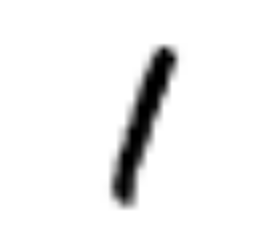

In [23]:
# Plot a random image
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

## プーリング層 (Pooling Layer)

多くの場合、深いネットワークを持つ場合は、特にパラメーター数を制御する必要があります。畳み込み層の出力の各層 (各層はフィルターの出力に対応する) は、プーリング層を持つことができます。プーリング層は、通常、次の目的で導入されます。

Often a times, one needs to control the number of parameters especially when having deep networks. For every layer of the convolution layer output (each layer, corresponds to the output of a filter), one can have a pooling layer. Pooling layers are typically introduced to:

- (ネットワークを高速化するように) 前の層の次元数を減らします。
- モデルを、画像内のオブジェクトの位置の変化により寛容にさせます。 例えば、数字が中間ではなく画像の片側に移された場合でも、分類器は分類タスクをうまく実行します。
- Reduce the dimensionality of the previous layer (speeding up the network),
- Makes the model more tolerant to changes in object location in the image. For example, even when a digit is shifted to one side of the image instead of being in the middle, the classifer would perform the classification task well.

プーリング ノードでの計算は、通常のフィード フォワード ノードよりもはるかに簡単です。重み、バイアス、活性化関数はありません。単純な集計関数 (最大値や平均値など) を使用して、出力を計算します。最も一般的に使用される関数は「max」です。最大プーリング ノードは、単に入力のフィルター位置に、対応する入力値の最大値を出力します。下図は、4 x 4 領域の入力値を示しています。最大プーリング ウィンドウ サイズは 2 x 2 で、左上隅から開始します。ウィンドウ内の最大値が、領域の出力になります。モデルがストライド パラメーターで指定された量だけ移動されるたびに (下図を参照)、最大プーリング操作が繰り返されます。

The calculation on a pooling node is much simpler than a normal feedforward node.  It has no weight, bias, or activation function.  It uses a simple aggregation function (like max or average) to compute its output.  The most commonly used function is "max" - a max pooling node simply outputs the maximum of the input values corresponding to the filter position of the input. The figure below shows the input values in a 4 x 4 region. The max pooling window size is 2 x 2 and starts from the top left corner. The maximum value within the window becomes the output of the region. Every time the model is shifted by the amount specified by the stride parameter (as shown in the figure below) and the maximum pooling operation is repeated. 
![maxppool](https://cntk.ai/jup/201/MaxPooling.png)

もう1つの選択肢は平均プーリングであり、最大値の代わりにその平均値を出力します。2 つの異なるプーリング走査は、以下のアニメーションに要約されています。

Another alternative is average pooling, which emits that average value instead of the maximum value. The two different pooling opearations are summarized in the animation below.

In [24]:
# Plot images with strides of 2 and 1 with padding turned on
images = [("https://www.cntk.ai/jup/c103d_max_pooling.gif" , 'Max pooling'),
          ("https://www.cntk.ai/jup/c103d_average_pooling.gif", 'Average pooling')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=300, height=300))

Max pooling


Average pooling


# 典型的な畳み込みネットワーク (Typical convolution network)

![mnist-conv-mp](http://www.cntk.ai/jup/conv103d_mnist-conv-mp.png)

典型的な CNN には、交互の畳み込み層とプーリング層のセットと、それに続く分類のための緻密出力層が含まれています。 あなたは、多くの古典的な深層ネットワーク (VGG、AlexNetなど) で、この構造の変種を見つけるでしょう。これは、CNTK_103C で使用した MLP ネットワークとは対照的です。これは、2 つの緻密層の後に、緻密出力層が続きます。

A typical CNN contains a set of alternating convolution and pooling layers followed by a dense output layer for classification. You will find variants of this structure in many classical deep networks (VGG, AlexNet etc).  This is in contrast to the MLP network we used in CNTK_103C, which consisted of 2 dense layers followed by a dense output layer.  

図は 2 次元 (2D) 画像の文脈で示されていますが、概念と CNTK コンポーネントはどの次元データにも適用できます。上図は、2 つの畳み込み層と 2 つの最大プーリング層を示しています。 典型的な戦略は、各中間層の空間サイズを縮小しながら、より深い層のフィルター数を増やすことです。

The illustrations are presented in the context of 2-dimensional (2D) images, but the concept and the CNTK components can operate on any dimensional data. The above schematic shows 2 convolution layer and 2 max-pooling layers. A typical strategy is to increase the number of filters in the deeper layers while reducing the spatial size of each intermediate layers. intermediate layers.

## タスク: MaxPoolingのネットワークの作成 (Task: Create a network with MaxPooling)

典型的な畳み込みネットワークは、組み合わさった畳み込み層、最大プーリング層を持ちます。以前のモデルには、畳み込み層しかありませんでした。このセクションでは、次のアーキテクチャのモデルを作成します。

Typical convolutional networks have interlacing convolution and max pool layers. The previous model had only convolution layer. In this section, you will create a model with the following architecture.

![conv-only](https://www.cntk.ai/jup/cntk103d_conv_max2.png)

このタスクを達成するには、CNTK の [MaxPooling](https://cntk.ai/pythondocs/cntk.layers.layers.html#cntk.layers.layers.MaxPooling) 関数を使用します。以下の「create_model」関数を編集し、MaxPooling 操作を追加します。

You will use the CNTK [MaxPooling](https://cntk.ai/pythondocs/cntk.layers.layers.html#cntk.layers.layers.MaxPooling) function to achieve this task. You will edit the `create_model` function below and add the MaxPooling operation. 

ヒント: 我々は、以下のいくつかのセルにソリューションを提供しています。先を見ずに、まず層を追加してみてください。

Hint: We provide the solution a few cells below. Refrain from looking ahead and try to add the layer yourself first.

In [25]:
# Modify this model
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                       pad=True, name='second_conv')(h)
            r = C.layers.Dense(num_output_classes, activation = None, name='classify')(h)
            return r
        
# do_train_test()

**クイズ**: MaxPooling と畳み込みのモデルに、いくつのパラメーターがありますか? 2 つのモデルのどちらで、エラー率が低くなっていますか?

**Quiz**: How many parameters do we have in the model with MaxPooling and Convolution? Which of the two models produces lower error rate?


**調査の推奨 (Exploration Suggestion)**
- LeakyRelu を使用すると、エラー率が向上しますか?
- (a) 純粋に 2 つの畳み込み層と (b) 交互に配置された 2 つの畳み込み層と最大プーリング層 のためのパラメータの総数で、最後の緻密層がパラメーターの何パーセントを占めていますか?
- Does the use of LeakyRelu help improve the error rate?
- What percentage of the parameter does the last dense layer contribute w.r.t. the overall number of parameters for (a) purely two convolutional layer and (b) alternating 2 convolutional and maxpooling layers   

# ソリューション (Solution)

In [26]:
# function to build model
def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(1,1), 
                                       pad=True, name="first_conv")(h)
            h = C.layers.MaxPooling(filter_shape=(2,2), 
                                    strides=(2,2), name="first_max")(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(1,1), 
                                       pad=True, name="second_conv")(h)
            h = C.layers.MaxPooling(filter_shape=(3,3), 
                                    strides=(3,3), name="second_max")(h)
            r = C.layers.Dense(num_output_classes, activation = None, name="classify")(h)
            return r
        
do_train_test()

Minibatch: 0, Loss: 2.3257, Error: 96.88%
Minibatch: 500, Loss: 0.0592, Error: 0.00%
Minibatch: 1000, Loss: 0.1007, Error: 3.12%
Minibatch: 1500, Loss: 0.1299, Error: 3.12%
Minibatch: 2000, Loss: 0.0077, Error: 0.00%
Minibatch: 2500, Loss: 0.0337, Error: 1.56%
Minibatch: 3000, Loss: 0.0038, Error: 0.00%
Minibatch: 3500, Loss: 0.0856, Error: 3.12%
Minibatch: 4000, Loss: 0.0052, Error: 0.00%
Minibatch: 4500, Loss: 0.0171, Error: 1.56%
Minibatch: 5000, Loss: 0.0266, Error: 1.56%
Minibatch: 5500, Loss: 0.0028, Error: 0.00%
Minibatch: 6000, Loss: 0.0070, Error: 0.00%
Minibatch: 6500, Loss: 0.0144, Error: 0.00%
Minibatch: 7000, Loss: 0.0083, Error: 0.00%
Minibatch: 7500, Loss: 0.0033, Error: 0.00%
Minibatch: 8000, Loss: 0.0114, Error: 0.00%
Minibatch: 8500, Loss: 0.0589, Error: 1.56%
Minibatch: 9000, Loss: 0.0186, Error: 1.56%
Training took 31.9 sec
Average test error: 1.05%
